## Flow Classification Task 

For this task we perform classification first on packet level and the on host level for scenario 10 in the CTU-13 dataset.

In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE, BorderlineSMOTE 
import seaborn as sns
import warnings
from helper_functions.classification import *
warnings.filterwarnings("ignore")

Keep the number of infected and normal ips given by the scenario.

In [2]:
infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206', '147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36, 147.32.80.9', '147.32.87.11']


Load the preprocessed data from the task 4.

In [4]:
data = pd.read_csv('./capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')
#data['Datetime'] = pd.to_datetime(data['Datetime'], infer_datetime_format=True)

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


In [5]:
# remove background 
data_nobground = data[ data['Label'] != 'Background']
data_nobground.shape

(645358, 13)

In [6]:
data_nobground.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
20,4.985,TCP,PA_,0,91,86277,1,LEGITIMATE,147.32.80.13,80,147.32.85.88,56949,2011-08-18 10:19:13.347
51,0.000,TCP,A_,0,1,66,1,LEGITIMATE,147.32.86.110,48102,74.125.232.214,443,2011-08-18 10:19:13.392
57,4.921,TCP,A_,0,49,3234,1,LEGITIMATE,147.32.85.88,56949,147.32.80.13,80,2011-08-18 10:19:13.411
73,4.742,TCP,A_,0,118,7080,1,LEGITIMATE,147.32.84.59,2768,74.125.108.208,80,2011-08-18 10:19:13.460
75,0.000,TCP,A_,0,1,60,1,LEGITIMATE,147.32.84.59,56058,74.125.232.215,443,2011-08-18 10:19:13.486


In [7]:
# We keep a copy of the data set to used for the host level.
new_nobground = data_nobground.copy()

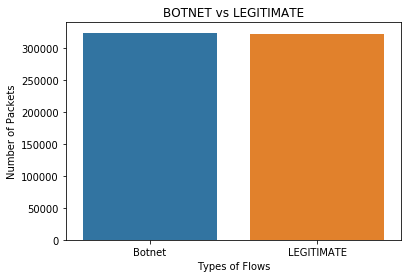

Number of Botnet:  323441
Number of Legitimate:  321917
Ratio:  1.0047341395452865


In [11]:
# Check for imbalance
ax = data_nobground['Label'].value_counts()
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x=ax.index, y= ax)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.show()

val_1 = len(data_nobground[data_nobground['Label'] == 'Botnet'])
val_2 = len(data_nobground[data_nobground['Label'] == 'LEGITIMATE'])
print("Number of Botnet: ", val_1)
print("Number of Legitimate: ", val_2)
print("Ratio: ", val_1/val_2)

In [12]:
# Produce labels 
label_mapping={}
label_mapping['Label'] = {'LEGITIMATE': 0, 'Botnet' : 1}
data_nobground.replace({'Label' : label_mapping['Label']}, inplace=True)

# Keep the labels 
labels= data_nobground['Label'].values


### Convesion of categorical data to numeric

Each column of type "object" is converted, based on an enumeration of its unique values. We did not use one-hot encoding for the conversion, as this would lead to unnecessary creation of extra columns, thus to the increase of the dimensionality of feature space.

In [13]:
char_cols =  data_nobground.dtypes.pipe(lambda x: x[x == 'object']).index
for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize( data_nobground[c])

In [14]:
# Drop the labels
X = data_nobground.drop(['Label'], axis = 1).values
print("Dataset shape: ", X.shape)

Dataset shape:  (645358, 12)


### Classification on packet level
We used the following classifiers:
- Naive Bayes
- Random Forrest 
- Logistic Reggresion

In [15]:
# 10-Fold stratified cross validation with shuffling of the dataset before extracting the stratified splits,
# used for estimating performance
num_splits = 10
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

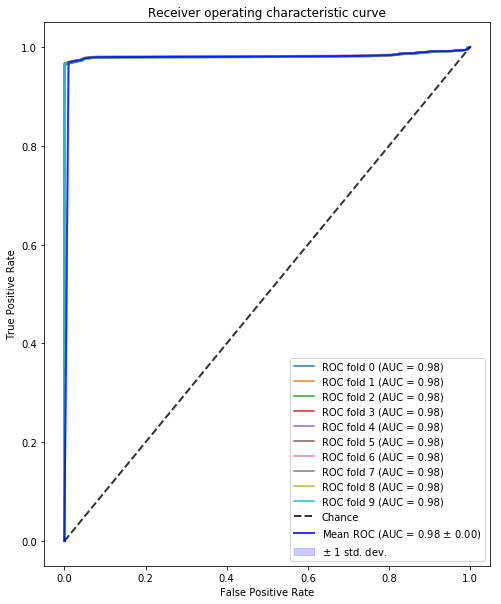

Confusion matrix, without normalization
[[317408   4509]
 [  9896 313545]]
Accuracy: 0.978
Precision: 0.986
Recall: 0.970
F1_score: 0.978


<Figure size 432x288 with 0 Axes>

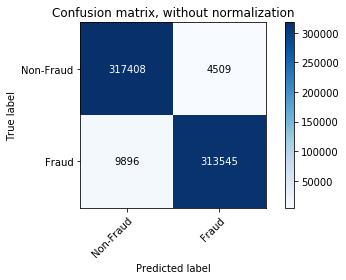

In [16]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
F1_score = 2*(precision*recall)/(precision+recall)

print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" % F1_score)



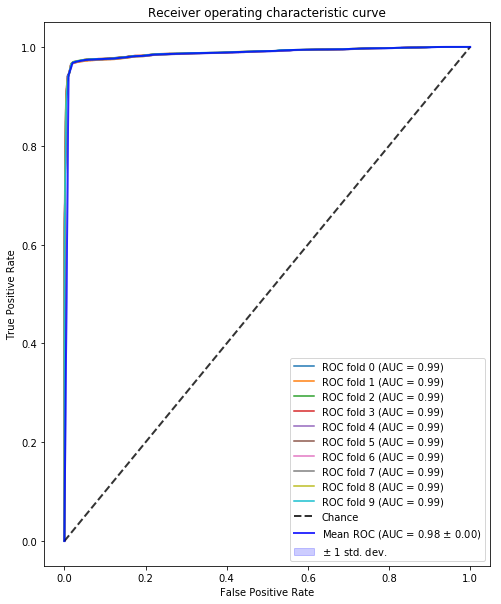

Confusion matrix, without normalization
[[289621  32296]
 [  7862 315579]]
Accuracy: 0.938
Precision: 0.900
Recall: 0.974
F1_score: 0.935


<Figure size 432x288 with 0 Axes>

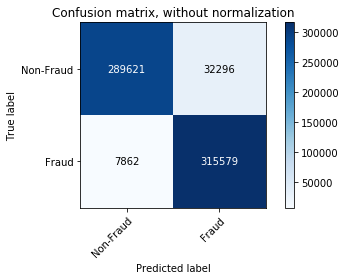

In [17]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
lr_mean_tpr, lr_std_tpr, lr_mean_auc, lr_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
F1_score = 2*(precision*recall)/(precision+recall)

print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" % F1_score)

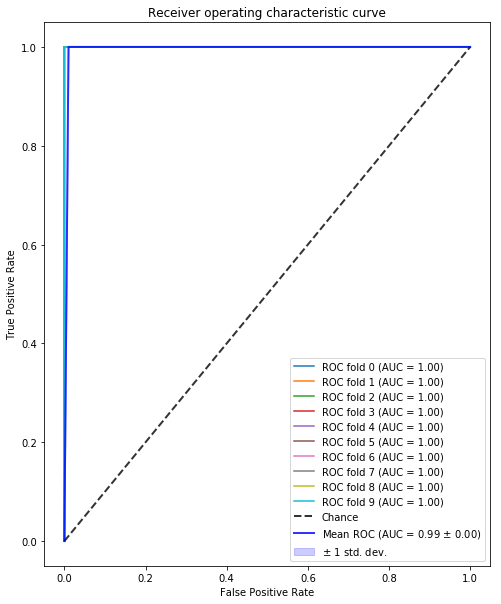

Confusion matrix, without normalization
[[321913      4]
 [    16 323425]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1_score: 1.000


<Figure size 432x288 with 0 Axes>

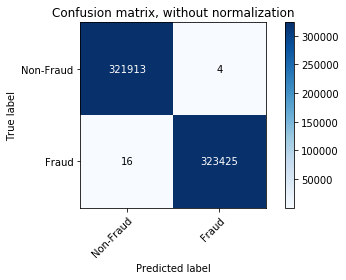

In [19]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
rf_mean_tpr, rf_std_tpr, rf_mean_auc, rf_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
F1_score = 2*(precision*recall)/(precision+recall)

print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" % F1_score)

### Classification on Host Level 
write more

In [18]:
''''
Group by Src ip 
constuct new features: 
the amount dst ips per unique src. 
the amount of src ports per unique src. 
the amount of dst ports per unique src.
'''''
data_perhost = new_nobground.groupby(by='Src_IP_Addr').sum()
data_perhost['num_Dst_IPs'] = new_nobground.groupby('Src_IP_Addr')['Dst_IP_Addr'].nunique()
data_perhost['num_Src_Ports'] = new_nobground.groupby('Src_IP_Addr')['Src_Port'].nunique()
data_perhost['num_Dst_Ports'] = new_nobground.groupby('Src_IP_Addr')['Dst_Port'].nunique()
# keep the ips 
hosts = data_perhost.index


In [19]:
#poio omorfo? isws k oxi 
d =pd.DataFrame()
group = new_nobground.groupby(['Src_IP_Addr'])
a = group.Src_IP_Addr.nunique()
a = pd.DataFrame(a)
a['usrc_port'] = group.Src_Port.nunique()
a['udest_ip'] = group.Dst_IP_Addr.nunique()
a['udest_port'] = group.Dst_Port.nunique()
a['Netflows'] = group.Flows.count()
a['Num_Bytes'] = group.Bytes.sum()
a['Num_Packets'] = group.Packets.sum()



In [20]:
a.head()

,Src_IP_Addr,usrc_port,udest_ip,udest_port,Netflows,Num_Bytes,Num_Packets
Src_IP_Addr,,,,,,,
10.10.20.233,1,23,1,1,75,8712,132
10.168.115.232,1,1,1,1,5,778,9
10.168.48.160,1,1,1,1,4,534,6
10.23.106.55,1,1,1,1,2,511,6
10.23.12.43,1,2,2,2,4,1583,6


In [31]:
data_perhost.head()

,Durat,Tos,Packets,Bytes,Flows,Label,num_Dst_IPs,num_Src_Ports,num_Dst_Ports
Src_IP_Addr,,,,,,,,,
10.10.20.233,50.096,0,132,8712,75,0,1,23,1
10.168.115.232,3.624,0,9,778,5,0,1,1,1
10.168.48.160,4.897,0,6,534,4,0,1,1,1
10.23.106.55,3.565,0,6,511,2,0,1,1,1
10.23.12.43,4.556,0,6,1583,4,0,2,2,2


In [20]:
X = data_perhost.values
labels = np.isin(data_perhost.index, infected_hosts).astype(int)
print(X.shape)
print("Imbalance ratio: ", np.sum(labels)/np.sum(labels==0))

(522, 8)
Imbalance ratio:  0.01953125


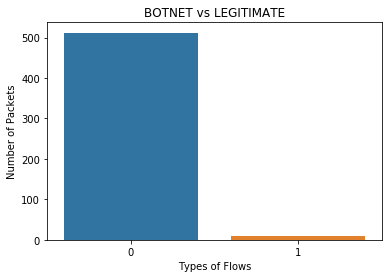

In [40]:
ax, counts = np.unique(labels, return_counts=True)
plt.title('BOTNET vs LEGITIMATE')
sns.barplot(x= ax, y=counts)  
plt.xlabel('Types of Flows')
plt.ylabel('Number of Packets')
plt.show()

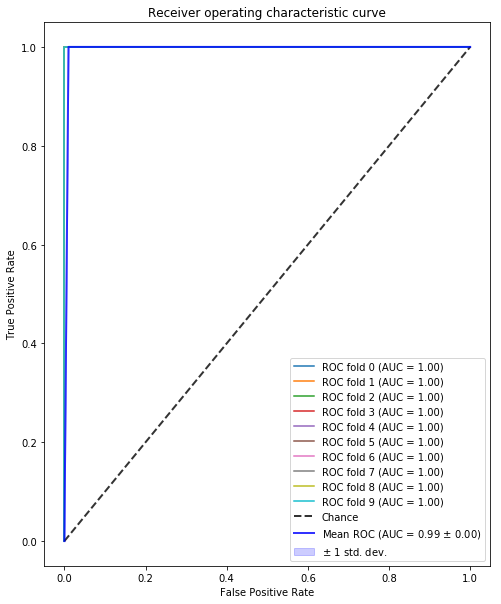

Confusion matrix, without normalization
[[512   0]
 [  0  10]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1_score: 1.000


<Figure size 432x288 with 0 Axes>

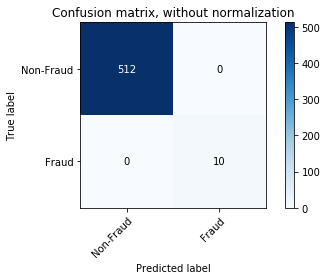

In [21]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
nb_mean_tpr, nb_std_tpr, nb_mean_auc, nb_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
F1_score = 2*(precision*recall)/(precision+recall)

print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" % F1_score)


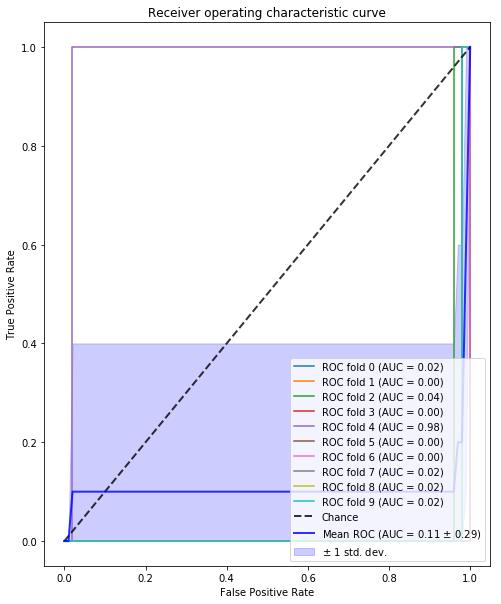

Confusion matrix, without normalization
[[503   9]
 [  9   1]]
Accuracy: 0.966
Precision: 0.982
Recall: 0.982
F1_score: 0.982


<Figure size 432x288 with 0 Axes>

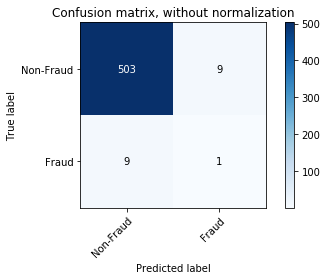

In [22]:
from  sklearn.linear_model import LogisticRegression as LR

clf = LR(C = 1, solver = 'lbfgs', multi_class = 'ovr', n_jobs=-1)
lr_mean_tpr, lr_std_tpr, lr_mean_auc, lr_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
F1_score = 2*(precision*recall)/(precision+recall)

print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" % F1_score)

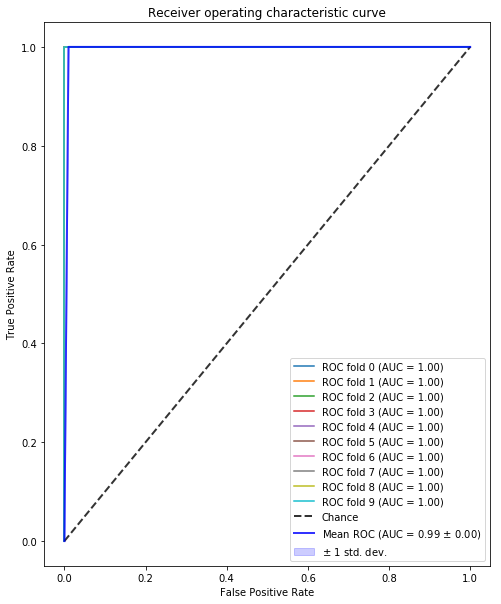

Confusion matrix, without normalization
[[510   2]
 [  0  10]]
Accuracy: 0.996
Precision: 0.996
Recall: 1.000
F1_score: 0.998


<Figure size 432x288 with 0 Axes>

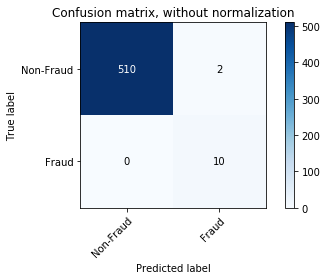

In [42]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)
rf_mean_tpr, rf_std_tpr, rf_mean_auc, rf_std_auc, mean_F1, std_F1, cm = roc_analysis(X, labels, clf, cv, True, True, True, False)

accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)
precision = cm[0,0]/(cm[0,0]+cm[0,1])
recall = cm[0,0]/(cm[0,0]+cm[1,0])
F1_score = 2*(precision*recall)/(precision+recall)

print("Accuracy: %.3f" %accuracy)
print("Precision: %.3f" % precision)
print("Recall: %.3f" %recall)
print("F1_score: %.3f" % F1_score)